# Problem Statement




Expedia has provided logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data is a random selection from Expedia and is not representative of the overall statistics.
We need to predict which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center etc.) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.
My goal is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.



<h3>Strategy to solve the problem:</h3>

The tasks involved are the following: <br/>
1. Download and loading the Train, Test and Destination dataset. 
2. Analysis of Train dataset based on hotel search by a user (Do statistical analysis of the data). 
3. Cleaning and preprocessing of datasets. 
4. Split the data into train and test dataset. 
5. Featuring the data to make it ready to execute in the machine learning algorithm. 
6. Since I do not have any idea the values for the output data might be, making it impossible for you to train the algorithm the way you normally would. So this is definitely an unsupervised machine learning problem.so I am going to run different machine learning model on this data set and found the best model in terms accuracy score.

7. If machine learning model does not give satisfactory accuracy then I will switch some different model in which this data will fits well and give me more accurate result.

8. I will store the top 5 predicted clusters for each user based on their search destination in a CSV file which will be my final result submission file. 

    

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from subprocess import check_output
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import matplotlib.pyplot as plt
import ml_metrics as metrics

Due to hardware limitations (my machine Ram is only 8GB), I am considering only 10K records from train dataset.

# Import data

In [2]:
Expedia_destinations = pd.read_csv('destinations.csv')
Expedia_test = pd.read_csv('test.csv')
#Expedia_train = pd.read_csv('train.csv', nrows=10000)
Expedia_train = pd.read_csv('train.csv',nrows=10000)

In [3]:
data_type={'is_booking':bool,'srch_ci' : np.str_, 'srch_co' : np.str_,
           'srch_adults_cnt' : np.int32, 'srch_children_cnt' : np.int32,
           'srch_rm_cnt' : np.int32, 'srch_destination_id':np.int32,
           'user_location_country' : np.int32, 'user_location_region' : np.int32,
           'user_location_city' : np.int32, 'hotel_cluster' : np.int32,
           'orig_destination_distance':np.float64, 'date_time':np.str_,
           'hotel_market':np.int32}
# d_type={'is_booking':bool, 'cnt':np.int32, 'hotel_cluster' : np.int32,'srch_destination_id':np.int32}

now I am going to dive in and explore hotel_cluster. I can use the value_counts method on Series to do this:

In [4]:
Expedia_train["hotel_cluster"].value_counts()

91    257
41    237
65    227
48    204
25    188
33    181
95    163
18    160
21    156
70    154
16    144
40    142
83    142
12    138
8     137
36    135
28    134
97    133
57    133
52    132
30    129
50    128
96    128
64    127
76    126
42    125
99    125
5     120
72    118
6     118
     ... 
69     75
55     75
31     74
17     74
89     74
38     72
43     69
35     68
11     68
87     67
19     66
94     63
45     63
79     62
86     60
92     58
66     58
67     57
44     55
53     53
71     51
3      51
80     49
24     44
49     41
93     37
75     32
88     29
27     16
74      9
Name: hotel_cluster, Length: 100, dtype: int64

<h3>Data Analysis:</h3>

<h4>Check Redundancy of the Data:</h4>
In order check whether there is redundancy in the features I am going to create correlation matrix and plot for the data which is depicted as follows 


In [5]:
corr = Expedia_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
site_name,1,-0.610056,0.0431937,-0.0928324,-0.137286,0.264061,-0.242078,0.0372455,-0.0561314,-0.0602006,-0.104782,-0.0745414,-0.0260977,0.0081735,-0.0669895,-0.011263,-0.0102458,0.163862,0.234928,-0.0923255,-0.0263366
posa_continent,-0.610056,1,0.287279,0.195505,0.16385,-0.12703,0.195892,0.00755842,0.0255781,0.107772,0.0559258,0.0665885,0.0130622,-0.0276866,0.0151151,-0.0116396,0.0231786,-0.231577,-0.142541,0.0533246,0.0220835
user_location_country,0.0431937,0.287279,1,0.184128,0.141829,0.12716,0.181098,-0.0248283,0.0308124,0.0971119,0.00282969,0.022707,0.0569491,-0.046619,-0.0575641,-0.00504397,0.0161485,-0.0336897,0.185689,0.0284251,-0.000624714
user_location_region,-0.0928324,0.195505,0.184128,1,0.276356,0.0662375,0.0457276,-0.0803036,0.0421449,0.0598834,0.0298266,0.0111622,0.0459279,0.0270749,0.0178221,0.0454864,-0.00549622,-0.00550175,-0.0652157,0.0623208,0.0312752
user_location_city,-0.137286,0.16385,0.141829,0.276356,1,0.134391,0.0732735,-0.0525526,0.0726449,-0.00627521,-0.0386949,-0.0667017,-0.0953246,-0.0557561,-0.0961861,0.00391074,0.00798473,0.0723318,-0.0455988,-0.00477364,0.00835325
orig_destination_distance,0.264061,-0.12703,0.12716,0.0662375,0.134391,1,-0.0376932,-0.0503785,0.0585172,-0.00513728,-0.121371,-0.112543,-0.11211,-0.108923,-0.140695,-0.0369138,0.025899,0.408688,0.244373,-0.056682,0.012138
user_id,-0.242078,0.195892,0.181098,0.0457276,0.0732735,-0.0376932,1,-0.144207,-0.152784,-0.00632375,0.00133443,0.0973384,0.027164,-0.0015625,0.0138484,0.00646953,0.00990372,-0.0592386,0.0113917,0.100252,-0.0389954
is_mobile,0.0372455,0.00755842,-0.0248283,-0.0803036,-0.0525526,-0.0503785,-0.144207,1,0.0943555,-0.0261816,0.0443235,-0.0503725,-0.0531614,-0.0130296,-0.00936181,-0.0475431,0.0149566,0.023069,-0.0167022,-0.0324063,-0.00242767
is_package,-0.0561314,0.0255781,0.0308124,0.0421449,0.0726449,0.0585172,-0.152784,0.0943555,1,0.050807,-0.0465034,-0.0378497,-0.0389669,-0.155015,-0.250973,-0.0550148,0.103186,0.0610977,-0.0835783,0.0317184,0.0687212
channel,-0.0602006,0.107772,0.0971119,0.0598834,-0.00627521,-0.00513728,-0.00632375,-0.0261816,0.050807,1,0.00390982,0.0479572,0.0509235,-0.0133464,0.000464484,0.0376177,-0.0193768,-0.0464899,-0.0874519,0.0503741,0.010784


Looking at the plots and numbers I can conclude that there are no significant correlation between features except some demographic features like user country and site (.uk, .ca etc). 



<h4>Distribution of data in hotel clusters:</h4>
From the co-relation graph I can see it has both user's booking as well as click data. In order to make data easy to handle we filtered to get only booking data. That reduced data to manageable number of examples. In data there are 100 clusters which are recalculated by expedia. We first took a look at the class distribution by histogram which is as follows

C:\Users\rhore\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


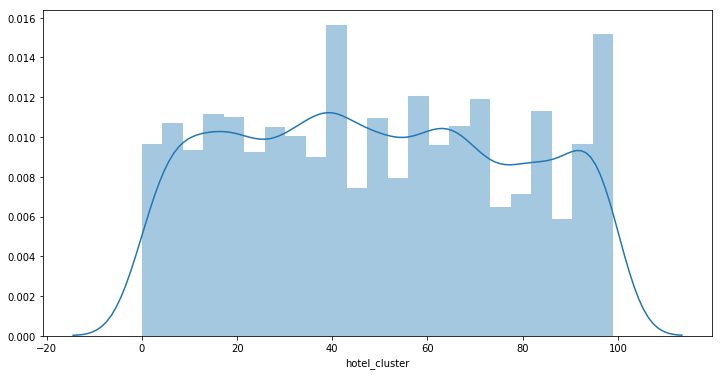

In [6]:
plt.figure(figsize=(12, 6))
sns.distplot(Expedia_train['hotel_cluster'])

The date time, checkin date and checkout date columns can not be used directly, we will extract year and month from them. First, we define a couple of functions to achieve that, and we also define a function to merge with destination.csv.

In [7]:
#train["date_time"] = pd.to_datetime(train["date_time"])
#train["year"] = train["date_time"].dt.year
#train["month"] = train["date_time"].dt.month
from datetime import datetime
def get_year(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass

def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass
    
def left_merge_dataset(left_dframe, right_dframe, merge_column):
    return pd.merge(left_dframe, right_dframe, on=merge_column, how='left')

In [8]:
Expedia_train["date_time"] = pd.to_datetime(Expedia_train["date_time"])
Expedia_train["year"] = Expedia_train["date_time"].dt.year
Expedia_train["month"] = Expedia_train["date_time"].dt.month

Since there are 100 hotel clusters let’s try to see the customers travel pattern of source and destination countries.

Customers travel pattern of source and destination countries:
Let’s plot the travel pattern of the customers to or from countries respectively in 1st and 2nd graph.


1st Graph:
Shown the travel pattern of the customers from the source countries.

2nd Graph:
Shown the travel pattern of the customers to the destination countries.


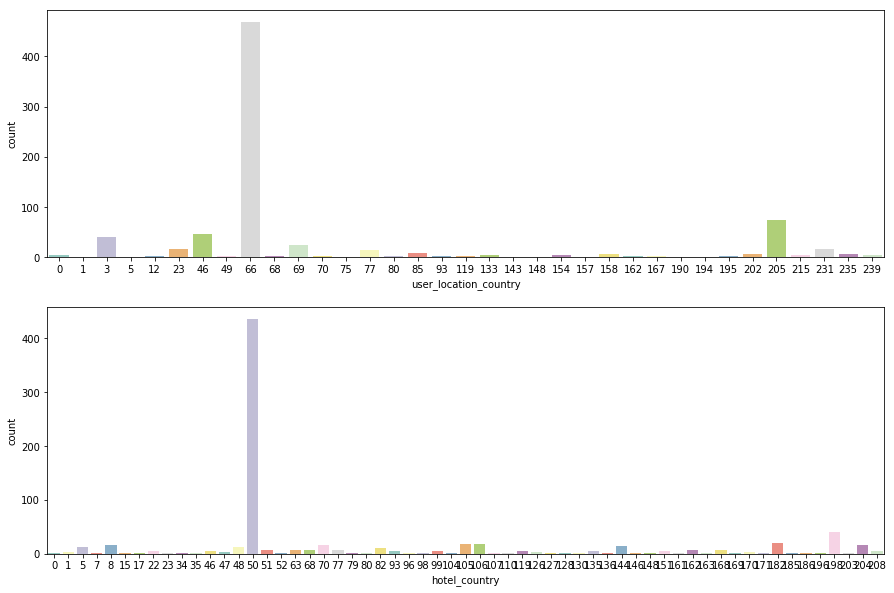

In [9]:
# Plot 

fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,10))

bookings_df = Expedia_train[Expedia_train["is_booking"] == 1]



# graph1:to show the countries from most the customer travel 
sns.countplot('user_location_country',data=bookings_df.sort_values(by=['user_location_country']),ax=axis1,palette="Set3")

# graph2: to show the countries from which most the customer travel  to differnet destinations
sns.countplot('hotel_country',data=bookings_df.sort_values(by=['hotel_country']),ax=axis2,palette="Set3")

In [10]:
Expedia_train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,0,3,2,50,628,1,2014,8
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,1,1,2,50,628,1,2014,8
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,8250,1,0,1,2,50,628,1,2014,8
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,14984,1,0,1,2,50,1457,80,2014,8
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,14984,1,0,1,2,50,1457,21,2014,8


# PCA

PCA is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables (entities each of which takes on various numerical values) into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors (each being a linear combination of the variables and containing n observations) are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables.

The main objectives of PCA are
	PCA reduces attribute space from a larger number of variables to a smaller number of factors and as such is a "non-dependent" procedure (that is, it does not assume a dependent variable is specified).
	 PCA is a dimensionality reduction or data compression method. The goal is dimension reduction and there is no guarantee that the dimensions are interpretable (a fact often not appreciated by (amateur) statisticians). 
	To select a subset of variables from a larger set, based on which original variables have the highest correlations with the principal component.


In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
Expedia_dest_small = pca.fit_transform(Expedia_destinations[["d{0}".format(i + 1) for i in range(149)]])
Expedia_dest_small = pd.DataFrame(Expedia_dest_small)
Expedia_dest_small["srch_destination_id"] = Expedia_destinations["srch_destination_id"]

In [12]:
#assign the dataset values into variable dataframes
Expedia_t1=Expedia_train
Expedia_df=Expedia_t1

In [13]:
Expedia_df.count()

date_time                    10000
site_name                    10000
posa_continent               10000
user_location_country        10000
user_location_region         10000
user_location_city           10000
orig_destination_distance     6271
user_id                      10000
is_mobile                    10000
is_package                   10000
channel                      10000
srch_ci                       9993
srch_co                       9993
srch_adults_cnt              10000
srch_children_cnt            10000
srch_rm_cnt                  10000
srch_destination_id          10000
srch_destination_type_id     10000
is_booking                   10000
cnt                          10000
hotel_continent              10000
hotel_country                10000
hotel_market                 10000
hotel_cluster                10000
year                         10000
month                        10000
dtype: int64

# PreProcessing of the Data

Column Analysis:
Date_time for check-in date and checkout date--------
I can see the date time, check-in date and checkout date columns can’t be used directly because the data type of them is string but value suggests they are timestamp, so I will extract year and month from them. First, I will define a couple of functions to achieve that, and we also define a function to merge with destination.csv.

We need to deal with srch_ci, date_time and srch_co column because the data type of these column is timestamp, so we can’t use them in our model. We have decided to drop them from the dataset.


In [14]:
Expedia_df["srch_ci"] = pd.to_datetime(Expedia_df["srch_ci"], format='%Y-%m-%d', errors="coerce")
Expedia_df["srch_co"] = pd.to_datetime(Expedia_df["srch_co"], format='%Y-%m-%d', errors="coerce")
props = {}
for prop in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
    props[prop] = getattr(Expedia_df["date_time"].dt, prop)

In [15]:
carryover = [p for p in Expedia_df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
for prop in carryover:
    props[prop] = Expedia_df[prop]

In [16]:
date_props = ["month", "day", "dayofweek", "quarter"]
for prop in date_props:
    props["ci_{0}".format(prop)] = getattr(Expedia_df["srch_ci"].dt, prop)
    props["co_{0}".format(prop)] = getattr(Expedia_df["srch_co"].dt, prop)
props["stay_span"] = (Expedia_df["srch_co"] - Expedia_df["srch_ci"]).astype('timedelta64[h]')
ret = pd.DataFrame(props)
ret = ret.join(Expedia_dest_small, on="srch_destination_id", how='left', rsuffix="dest")
ret = ret.drop("srch_destination_iddest", axis=1)

In [17]:
Expedia_dest_small.head()

,0,1,2,srch_destination_id
0,-0.044268,0.169419,0.032522,0
1,-0.440761,0.077405,-0.091573,1
2,0.001033,0.020677,0.012106,2
3,-0.480467,-0.040345,-0.019320,3
4,-0.207253,-0.042694,-0.011744,4


In [18]:
Expedia_df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,0,3,2,50,628,1,2014,8
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,1,1,2,50,628,1,2014,8
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,8250,1,0,1,2,50,628,1,2014,8
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,14984,1,0,1,2,50,1457,80,2014,8
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,14984,1,0,1,2,50,1457,21,2014,8


After dropping unwanted columns and data processing I want plot the co-relation matrix to see how our data co-relates in the data set.

In [19]:
corr = Expedia_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month
site_name,1,-0.610056,0.0431937,-0.0928324,-0.137286,0.264061,-0.242078,0.0372455,-0.0561314,-0.0602006,-0.104782,-0.0745414,-0.0260977,0.0081735,-0.0669895,-0.011263,-0.0102458,0.163862,0.234928,-0.0923255,-0.0263366,-0.0750398,0.123577
posa_continent,-0.610056,1,0.287279,0.195505,0.16385,-0.12703,0.195892,0.00755842,0.0255781,0.107772,0.0559258,0.0665885,0.0130622,-0.0276866,0.0151151,-0.0116396,0.0231786,-0.231577,-0.142541,0.0533246,0.0220835,-0.00928406,-0.0585751
user_location_country,0.0431937,0.287279,1,0.184128,0.141829,0.12716,0.181098,-0.0248283,0.0308124,0.0971119,0.00282969,0.022707,0.0569491,-0.046619,-0.0575641,-0.00504397,0.0161485,-0.0336897,0.185689,0.0284251,-0.000624714,-0.0191909,4.92416e-06
user_location_region,-0.0928324,0.195505,0.184128,1,0.276356,0.0662375,0.0457276,-0.0803036,0.0421449,0.0598834,0.0298266,0.0111622,0.0459279,0.0270749,0.0178221,0.0454864,-0.00549622,-0.00550175,-0.0652157,0.0623208,0.0312752,-0.00916029,-0.0971418
user_location_city,-0.137286,0.16385,0.141829,0.276356,1,0.134391,0.0732735,-0.0525526,0.0726449,-0.00627521,-0.0386949,-0.0667017,-0.0953246,-0.0557561,-0.0961861,0.00391074,0.00798473,0.0723318,-0.0455988,-0.00477364,0.00835325,0.107903,0.00420888
orig_destination_distance,0.264061,-0.12703,0.12716,0.0662375,0.134391,1,-0.0376932,-0.0503785,0.0585172,-0.00513728,-0.121371,-0.112543,-0.11211,-0.108923,-0.140695,-0.0369138,0.025899,0.408688,0.244373,-0.056682,0.012138,0.0745622,0.0856597
user_id,-0.242078,0.195892,0.181098,0.0457276,0.0732735,-0.0376932,1,-0.144207,-0.152784,-0.00632375,0.00133443,0.0973384,0.027164,-0.0015625,0.0138484,0.00646953,0.00990372,-0.0592386,0.0113917,0.100252,-0.0389954,-0.0431841,-0.120121
is_mobile,0.0372455,0.00755842,-0.0248283,-0.0803036,-0.0525526,-0.0503785,-0.144207,1,0.0943555,-0.0261816,0.0443235,-0.0503725,-0.0531614,-0.0130296,-0.00936181,-0.0475431,0.0149566,0.023069,-0.0167022,-0.0324063,-0.00242767,0.0349685,0.0269909
is_package,-0.0561314,0.0255781,0.0308124,0.0421449,0.0726449,0.0585172,-0.152784,0.0943555,1,0.050807,-0.0465034,-0.0378497,-0.0389669,-0.155015,-0.250973,-0.0550148,0.103186,0.0610977,-0.0835783,0.0317184,0.0687212,0.0490248,0.0102446
channel,-0.0602006,0.107772,0.0971119,0.0598834,-0.00627521,-0.00513728,-0.00632375,-0.0261816,0.050807,1,0.00390982,0.0479572,0.0509235,-0.0133464,0.000464484,0.0376177,-0.0193768,-0.0464899,-0.0874519,0.0503741,0.010784,-0.0611481,-0.0279226


Dropping the timestamp columns from the datasets

In [20]:
#dropping the timestamp columns from the datasets
Expedia_df = Expedia_df.drop(['date_time', 'srch_ci', 'srch_co'], axis=1)

For known combinations of user location cities, origin-destination distances and search destinations, will definitely help finding hotel cluster.

In [21]:
pieces = [Expedia_df.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
aggregate_df = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
aggregate_df.dropna(inplace=True)

In [22]:
aggregate_df.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
11                  50            824          94               1      2
16                  50            419          7                1      2
19                  102           1522         20               0      1
                                               30               0      1
                                               40               0      4

In [23]:
aggregate_df['sum_and_cnt'] = 0.85*aggregate_df['sum'] + 0.15*aggregate_df['count']
aggregate_df = aggregate_df.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
aggregate_df.reset_index(inplace=True)

aggregate_df.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,11,50,824,94,1.0,1.000000,1.000000
1,16,50,419,7,1.0,1.000000,1.000000
2,19,102,1522,20,NaN,0.142857,0.142857
3,19,102,1522,30,NaN,0.142857,0.142857
4,19,102,1522,40,NaN,0.571429,0.571429


In [24]:
aggregate_pivot = aggregate_df.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_cnt').reset_index()

In [25]:
aggregate_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,16,50,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19,102,1522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56,77,217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,66,50,423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:

Expedia_df = pd.merge(Expedia_df, Expedia_destinations, how='left', on='srch_destination_id')
Expedia_df = pd.merge(Expedia_df, aggregate_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])

In [27]:
Expedia_df.fillna(0, inplace=True)
Expedia_df.shape

(10000, 272)

In [28]:
Expedia_df.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,90,91,92,93,94,95,96,97,98,99
0,2,3,66,348,48862,2234.2641,12,0,1,9,...,0.002425,0.025869,0.000000,0.0,0.0,0.0,0.002425,0.0,0.0,0.0
1,2,3,66,348,48862,2234.2641,12,0,1,9,...,0.002425,0.025869,0.000000,0.0,0.0,0.0,0.002425,0.0,0.0,0.0
2,2,3,66,348,48862,2234.2641,12,0,0,9,...,0.002425,0.025869,0.000000,0.0,0.0,0.0,0.002425,0.0,0.0,0.0
3,2,3,66,442,35390,913.1932,93,0,0,3,...,0.000000,0.000000,0.090909,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,2,3,66,442,35390,913.6259,93,0,0,3,...,0.000000,0.000000,0.090909,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [29]:
#only selecting the successful booking 
Expedia_df = Expedia_df.loc[Expedia_df['is_booking'] == 1]
Expedia_dataset_df=Expedia_df

In [30]:
predict_X = Expedia_df.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1)
target_y = Expedia_df.hotel_cluster

Since I do not have any idea the values for the output data might be, making it impossible for you to train the algorithm the way you normally would. So this is definitely an unsupervised machine learning problem.
I am going to use the below list of algorithms of the unsupervised learning on the given dataset and will check which performs better among them


Algorithms to evaluate-------------<br/>
1>Random Forest<br/>
2>Support Vector Machine(SVM)<br/>
3>Random Forests(RF)<br/>
4>KNeighbors Classifier<br/>
5>Naïve Bayes<br/>


<h4>Evaluation Metrics:</h4>
I am planning to use Mean Average Precision as my evaluation matrix.
Mean Average Precision: 
The mean average precision (MAP) of a set of queries is defined as such:

 MAP =  limit(q=1 to Q)AveP(q)/Q
 
Here Q is the number of queries in the set and AveP(q) is the average precision (AP) for a given query, q.
The formula is essentially telling us is that, for a given query, q, we calculate it’s corresponding AP, and then the mean of the all these AP scores would give us a single number, called the MAP, which quantifies how good our model is at performing the query.

Advantages of MAP over AP: The MAP for object detection is the average of the AP calculated for all the classes. So it gives more accurate result.


<h4>Random Forest:</h4>

Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction



In [31]:
#use Random forest
clf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=273,max_depth=10,random_state=0))
np.mean(cross_val_score(clf, predict_X,target_y, cv=10))

C:\Users\rhore\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0.5268103353926417

<h4>SVM:</h4>

“Support Vector Machine” (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. However,  it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes very well


In [32]:
#use SVM
from sklearn import svm

clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
np.mean(cross_val_score(clf, predict_X, target_y, cv=10))

C:\Users\rhore\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0.599432368905237

<h4>Naive Bayes:</h4>

Naive Bayes classifiers are a collection of classification algorithms based on Bayes’ Theorem. It is not a single algorithm but a family of algorithms where all of them share a common principle, i.e. every pair of features being classified is independent of each other.

In [33]:
# use  Naive Bayes
from sklearn.naive_bayes import GaussianNB

clf = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
np.mean(cross_val_score(clf, predict_X, target_y, cv=10))

C:\Users\rhore\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0.20205414600540159

<h4>Logistic Regression:</h4>

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [34]:
#use Logistic Regression
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class='ovr'))
np.mean(cross_val_score(clf, predict_X, target_y, cv=10))

C:\Users\rhore\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0.6131585512154827

<h4>KNeighbors Classifier:</h4>

K-Nearest Neighbors is a method that simply looks at the observation that are nearest to the one it’s trying to predict, and classifies the point of interest based on the majority of those around it.


In [35]:
#use KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(clf, predict_X, target_y, cv=10, scoring='accuracy'))

C:\Users\rhore\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0.5784626901012316

In [36]:
from prettytable import PrettyTable
x = PrettyTable()
x.title = 'Overall Observation'
x.field_names = ["Serial No","Model","Mean Average Precision Score"]

x.add_row(['1', 'Random Forest',0.526810335])
x.add_row(['2', 'SVM',0.599432369 ])
x.add_row(['3', 'Naive Bayes',0.202054146 ])
x.add_row(['4', 'Kneighbors Classifier',0.5784626901012316 ])
x.add_row(['4', 'Logistic Regression',0.613158551 ])

print(x)

+------------------------------------------------------------------+
|                       Overall Observation                        |
+-----------+-----------------------+------------------------------+
| Serial No |         Model         | Mean Average Precision Score |
+-----------+-----------------------+------------------------------+
|     1     |     Random Forest     |         0.526810335          |
|     2     |          SVM          |         0.599432369          |
|     3     |      Naive Bayes      |         0.202054146          |
|     4     | Kneighbors Classifier |      0.5784626901012316      |
|     4     |  Logistic Regression  |         0.613158551          |
+-----------+-----------------------+------------------------------+


Logistic Regression algorithm gives the best score of Mean Average Precision on the dataset


<h3>Performance Tuning of hypermeters:</h3>
I will use k-fold cross validation to estimate the accuracy of our prediction and use a Random Forest algorithm to predict the hotel clusters.

In [37]:
predictors = [c for c in Expedia_dataset_df.columns if c not in ["hotel_cluster"]]
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
scores = cross_validation.cross_val_score(clf, Expedia_dataset_df[predictors], Expedia_dataset_df['hotel_cluster'], cv=3)
scores

C:\Users\rhore\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\rhore\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


array([0.10238908, 0.13076923, 0.17410714])

The accuracy is not good so lets try 2 fold cross validation and train 10 decision trees per label

In [38]:
predictors = [c for c in Expedia_dataset_df.columns if c not in ["hotel_cluster"]]
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

#cv = KFold(n_splits=2)
clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
scores = cross_validation.cross_val_score(clf, Expedia_dataset_df[predictors], Expedia_dataset_df['hotel_cluster'], cv=2)
scores

C:\Users\rhore\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


array([0.11538462, 0.11911357])

let also try to plot the prediction values in a graph

C:\Users\rhore\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


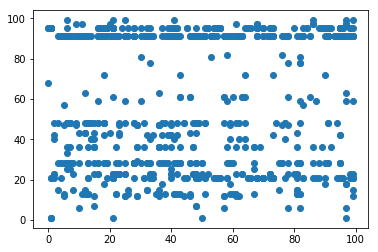

In [39]:
from sklearn.cross_validation import cross_val_predict
cross_val_predictions = cross_val_predict(clf, Expedia_dataset_df[predictors], Expedia_dataset_df['hotel_cluster'], cv=2)
plt.scatter(Expedia_dataset_df['hotel_cluster'],cross_val_predictions)

This score is also pretty low and also we can't predict the top hotel clusters, so lets try a different approach other than the machine learning.

# Top clusters based on hotel_cluster


I think if I chose orig_destination_distance then I will not get the better accurate result,so 
If I aggregate on srch_destination_id I will  be able to find the most popular hotel clusters for each destination better.<br/> 
I will then be able to predict that a user who searches for a destination is going to one of the most popular hotel clusters for that destination. <br/>
I will first generate scores for each hotel_cluster in each srch_destination_id. I will give more weightage to bookings higher than clicks. This is because the test data is all booking data and this is what I want to predict. I also want to include click information, but down weight it to reflect this






As a reference I will try to plot a graph to show number of count and percentage of successful booking by customers in each month from train dataset.  

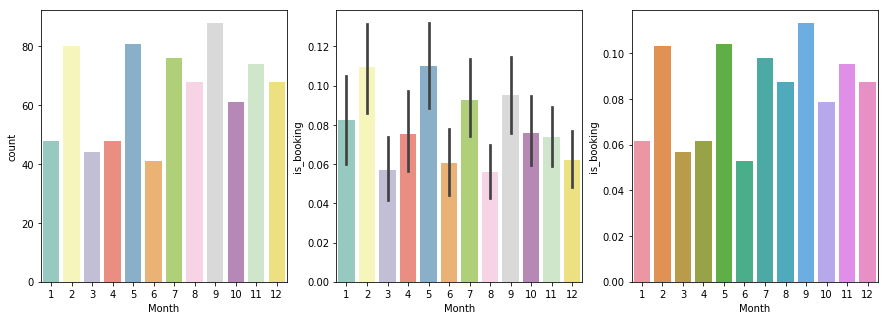

In [40]:

Expedia_t1['Year']   = Expedia_t1['srch_ci'].apply(lambda x: int(str(x)[:4]) if x == x else np.nan)
Expedia_t1['Month']  = Expedia_t1['srch_ci'].apply(lambda x: int(str(x)[5:7]) if x == x else np.nan)


fig, (axis1,axis2,axis3) = plt.subplots(1,3,sharex=True,figsize=(15,5))

# Plot How many bookings in each month
sns.countplot('Month',data=Expedia_t1[Expedia_t1["is_booking"] == 1],order=list(range(1,13)),palette="Set3",ax=axis1)

# Plot The percentage of bookings of each month(sum of month bookings / count of bookings(=1 OR =0) of a month)
# sns.factorplot('Month',"is_booking",data=Expedia_t1, order=list(range(1,13)), palette="Set3",ax=axis2)
sns.barplot('Month',"is_booking",data=Expedia_t1, order=list(range(1,13)), palette="Set3",ax=axis2)

# Plot The percentage of bookings of each month compared to all bookings(sum of month bookings / count of bookings(=1) of all months)
month_sum = Expedia_t1[['Month', 'is_booking']].groupby(['Month'],as_index=False).sum()
month_sum['is_booking'] = month_sum['is_booking'] / len(Expedia_t1[Expedia_t1['is_booking'] == 1])

sns.barplot(x='Month', y='is_booking', order=list(range(1,13)), data=month_sum,ax=axis3)

<h3>Important features of the Model:</h3>

As I have mentioned before that I am going to consider successful booking srch_destination_id and hotel cluster as the 2 most important features in my model. I will give more weightage on the successful booking (where is_booking=1) than the failure booking (where is_booking=0) here

<h5>Hotel_cluster:</h5>
Showing the count of successful booking in each hotel_cluster in the below graph


<h5>Note:</h5>
For visual clarity I have shown First 40 hotel_cluster from the dataset

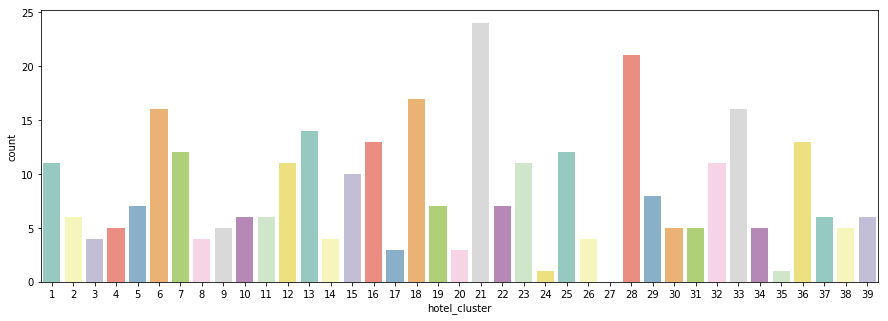

In [41]:
fig, (axis1) = plt.subplots(1,1,sharex=True,figsize=(15,5))

# Plot How many succesful bookings in each hotel_cluster
sns.countplot('hotel_cluster',data=Expedia_t1[Expedia_t1["is_booking"] == 1],order=list(range(1,40)),palette="Set3",ax=axis1)



<h5>srch_destination_id:</h5>
Showing the count of successful booking in each srch_destination_id in the below graph


<h5>Note:</h5>
 For visual clarity I have shown First 40 srch_destination_id from the dataset  

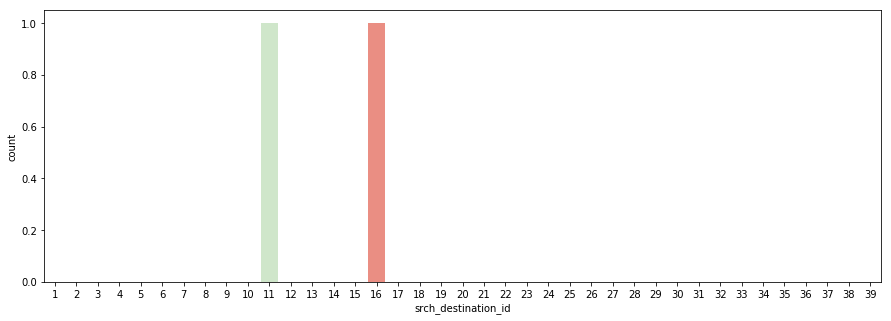

In [42]:
fig, (axis1) = plt.subplots(1,1,sharex=True,figsize=(15,5))

# Plot How many succesful bookings in each srch_destination_id
sns.countplot('srch_destination_id',data=Expedia_t1[Expedia_t1["is_booking"] == 1],order=list(range(1,40)),palette="Set3",ax=axis1)

<h4>Steps are as follows:</h4>
<br/>
<h5>Step1:</h5>
I will split our sample data set so that anything after July 2014 is in test_subset (our new test subset) and anything before is in train_subset.

In [43]:
Expedia_train_subset = Expedia_t1[((Expedia_t1.year == 2013) | ((Expedia_t1.year == 2014) & (Expedia_t1.month < 8)))]
Expedia_test_subset=Expedia_t1[((Expedia_t1.year == 2014) & (Expedia_t1.month >= 8))]

<h5>Step2:</h5>
My test set only contains booking events. When is_booking is 0, it means that instance was a click and didn't end in a booking. So I only include bookings in test_subset

In [44]:
Expedia_test_subset = Expedia_test_subset[Expedia_test_subset.is_booking == 1]

In [45]:
Expedia_test_subset.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,Year,Month
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,1,1,2,50,628,1,2014,8,2014.0,8.0
72,2014-11-23 18:02:20,30,4,195,991,47725,NaN,1048,0,0,...,1,1,3,151,69,36,2014,11,2015.0,6.0
128,2014-10-29 14:32:19,2,3,66,174,40365,8456.8294,1713,0,0,...,1,1,3,5,89,38,2014,10,2014.0,11.0
133,2014-12-05 09:58:15,2,3,66,174,21855,8393.1607,1713,0,0,...,1,1,3,5,89,81,2014,12,2014.0,12.0
268,2014-12-28 20:38:09,24,2,3,64,9448,NaN,2451,0,0,...,1,1,6,105,29,10,2014,12,2015.0,2.0


<h5>Step3:</h5>
Group train_subset by srch_destination_id and hotel_cluster
Iterate through each group 

Assign 1 point to each hotel cluster where is_booking is True<br/>
Assign .15 points to each hotel cluster where is_booking is False<br/>
Assign the score to the srch_destination_id / hotel_cluster combination in a dictionary<br/>

In [46]:
#assign the dataset value into a variable to develop the model

def make_key(items):
    return "_".join([str(i) for i in items])

match_cols = ["srch_destination_id"]
cluster_cols = match_cols + ['hotel_cluster']
groups = Expedia_train_subset.groupby(cluster_cols)
top_clusters = {}
for name, group in groups:
    clicks = len(group.is_booking[group.is_booking == False])
    bookings = len(group.is_booking[group.is_booking == True])
    
    score = bookings + .15 * clicks
    
    clus_name = make_key(name[:len(match_cols)])
    if clus_name not in top_clusters:
        top_clusters[clus_name] = {}
    top_clusters[clus_name][name[-1]] = score

<h5>Step4:</h5>
I want to create a dictionary where each key is a srch_destination_id and each value in will be another dictionary that contains the hotel clusters as keys and scores as the values. After that I want to transform this dictionary to find the top 5 hotel clusters for each srch_destination_id.

In [47]:
import operator

cluster_dict = {}
for n in top_clusters:
    tc = top_clusters[n]
    top = [l[0] for l in sorted(tc.items(), key=operator.itemgetter(1), reverse=True)[:5]]
    cluster_dict[n] = top    


<h5>Step5:Generating Predictions based on destination:</h5>

I have found the top clusters for each srch_destination_id, now to make predictions I have to follow the below steps<br/>

Iterate through each row in test subset.<br/>
Extract the srch_destination_id for the row.<br/>
Find the top clusters for that destination id.<br/>
Append the top clusters to predictions.<br/>

In [48]:
predictions = []
for index, row in Expedia_test_subset.iterrows():
    key = make_key([row[m] for m in match_cols])
    if key in cluster_dict:
        predictions.append(cluster_dict[key])
    else:
        predictions.append([])

In [49]:
predictions[0:5]

[[45, 1, 88, 24, 54], [81, 32, 29, 46, 36], [], [], []]

<h4>Calculating error</h4>
Now my predictions are ready, now I can compute accuracy of the model using the mapk function 

In [50]:
metrics.mapk([[l] for l in Expedia_test_subset["hotel_cluster"]], predictions, k=5)

0.130249343832021

So now my accuracy is times better than when I used Random Forest Classifier

<h3>Benchmarking Model:</h3> 
Matching Users for Better Accuracy


To improve the model score and accuracy of the predicted value I am going to take the below steps

I am trying to find users in the training set that match users in the testing set. In order to do this, I am going to:<br/>
•	Split the training data into groups based on the match columns.<br/>
•	Loop through the testing data.<br/>
•	Create an index based on the match columns.<br/>
•	Append any matches between the testing data and the training data using the groups.<br/>





In [51]:
# I am here matching the users for better accurate output
match_cols = ['user_location_country', 'user_location_region', 'user_location_city', 'hotel_market', 'orig_destination_distance']

groups = Expedia_train_subset.groupby(match_cols)
    
def generate_exact_matches(row, match_cols):
    index = tuple([row[t] for t in match_cols])
    try:
        group = groups.get_group(index)
    except Exception:
        return []
    clus = list(set(group.hotel_cluster))
    return clus

exact_matches = []
for i in range(Expedia_test_subset.shape[0]):
    exact_matches.append(generate_exact_matches(Expedia_test_subset.iloc[i], match_cols))

At the end of this loop, I will have a list of lists that contain any exact matches between the training and the testing sets. However, there aren’t that many matches. To accurately evaluate error, I will have to combine these predictions with my earlier predictions. Otherwise, I will get a very low accuracy value, because most rows have empty lists for predictions.

In [52]:
most_common_clusters = list(Expedia_train_subset.hotel_cluster.value_counts().head().index)

<h4>Combining predictions</h4>

I am going to combine different lists of predictions to boost accuracy. Doing so will also help us see how good our exact match strategy is. To do this, I will have to:<br/>
•	Combine exact_matches, predictions, and most_common_clusters.<br/>
•	Only take the unique predictions, in sequential order, using the f5 function from here<br/>
•	Ensure we have a maximum of 5 predictions for each row in the testing set.<br/>



In [53]:
def f5(seq, idfun=None): 
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result
    

In [54]:
 full_predictions= [f5(exact_matches[p] + predictions[p] + most_common_clusters)[:5] for p in range(len(predictions))]

<h4>Evaluating error of the new improved model:</h4>

Now I am going to calculate the accuracy of the new improved model using the mapk function

In [55]:
metrics.mapk([[l] for l in Expedia_test_subset["hotel_cluster"]], full_predictions, k=5)

0.1758530183727034

Now my Mean Average Precision is even better after the performance tuning in the benchmark model.

Now I am Converting the full_predtictions array into dataframe to display the prediction result for each user_ids(row)

In [56]:
from pandas.core.frame import DataFrame
predictionResult=DataFrame(full_predictions)
predictionResult.head()

,0,1,2,3,4
0,45,1,88,24,54
1,81,32,29,46,36
2,91,65,41,48,25
3,91,65,41,48,25
4,91,65,41,48,25


<h3>Limitations:</h3>
This model also have few limitations and those are defining factor of it accuracy.<br/>
•I am computing error on a sample of the training set<br/>
•I am only using a small subset of data for training, and it may be more accurate if we use the full training set.<br/>
•I am not using any randomization techniques to use some random numbers in this algorithm.<br/>


# Final submission of the predicted output

<h3>Final conclusion (Result):</h3></br>
My final output displayed the prediction of top 5 clusters which a user going to book as per their search destination 

In [57]:
write_prediction = [" ".join([str(l) for l in p]) for p in full_predictions]

In [58]:
finalPredictionOutput=DataFrame(write_prediction,columns=["hotel_cluster"])
finalPredictionOutput.head()

,hotel_cluster
0,45 1 88 24 54
1,81 32 29 46 36
2,91 65 41 48 25
3,91 65 41 48 25
4,91 65 41 48 25


In [59]:
finalPredictionOutput.to_csv('Expedia_Final_predict_output.csv',header=True, index_label='id')

<h3>Improvement:</h3>

1.	To try with more data points (on a system more than 8GB RAM & high end processor)
2.	Finding similarity between users, then adjusting hotel cluster scores based on similarity
3.	Using similarity between destinations to group multiple destinations together
4.	Sampling down the data even more.
5.	Parallelizing operations across multiple cores.
6.	Exploring the link between hotel clusters and regions more





<h3>Robustness of the model:</h3> 

My model fits well of the given data set but I am still not sure about the real life implementation on this.<br/>
My model predicts hotel clusters on the basis search destination by the user.<br/> 
Now the hotel cluster tagging in test and train may be different because they are from different years or season and on the basis of this the cluster assignment also will also be changed.<br/>
Example: in winter a hotel is cheap and not-popular and will be assigned to cluster A, and in summer the same hotel will become expensive and popular and will be assigned to cluster B. In addition to yearly seasonality, we can observe weekly seasonality as well (hotels are cheaper and not popular in weekdays, and more expensive and popular during weekends).



<h3>Conclusion:</h3>

  1>I have chosen Mean Average Precision (MAP) as my evaluation matrix because object detection for MAP is the average of the AP calculated for all the classes. So it gives more accurate result.

  2> in this problem, I do not have any idea the values for the output data might be, making it impossible for me to train the algorithm the way I normally would. So this is definitely an unsupervised machine learning problem.so I am going to run different machine learning model on this data set and found the best model in terms accuracy score.
I have used Random Forest, SVM, Logistic Regression, Naïve Bayes and KNeighbors Classifier to train my model.

   3> I have used PCA to reduce dimension of the data set and also preserve the variance between rows at the same time.

  4> I have applied co-relation matrix on the data set and found that nothing is linearly correlated with the target (hotel_cluster) and that is the reason the machine learning algorithms is not giving me good accurate value on the test dataset.
For example, having a higher cluster number isn’t tied to having a higher srch_destination_id. Unfortunately, this means that techniques like linear regression and logistic regression won’t work well on this data sets.
 
 5> I have created a new model other than the machine learning algorithms and have taken the srch_destination_id and hotel_cluster and is_booking as most important features and I have received the best accuracy score on this dataset.

 6> Using the above model I have predicted top 5 hotel cluster for each user id and store the final result in a CSV file. This output csv file is my final submission file for this project as mentioned in the problem statement. 


<h3>Challenge and Difficulties:</h3>
This is very interesting and challenging problem which I have faced till date.
The main challenge which I have faced here are given below:<br/>
•	Some columns datatypes in the train/test data set is String and data actually is in time stamp format, so I have to break those values and find the date, month, year to use in my machine learning algorithm.<br/>
•	Nothing is linearly correlated with the target (hotel_cluster), meaning I can’t use fast machine learning techniques like linear regression.<br/>
•	The machine learning algorithms do not give me good accuracy value so I have to developed some new model which gives good accuracy.<br/>
•	The train data size is huge and I have some hardware limitation, so I have not able to use the entire train dataset. I have used only a subset of train dataset.<br/>

I am not entirely satisfy with the final accuracy score but due to hardware constraints I have not able to use the entire train dataset which I hoping will surely give me better accuracy value of my model.